In [2]:
# load swap data from csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load data
df = pd.read_csv('LQTYETH_swap.csv', index_col=0)


In [4]:
df['AMM_price'] = abs(df['amount_token0'] / df['amount_token1'])

df['abs_amount_token0'] = abs(df['amount_token0'])

df['weighted_price'] = df['AMM_price'] * df['abs_amount_token0']

# Group the dataframe by 'block_number' and aggregate the columns
grouped_df = df.groupby('block_number').agg({
    'amount_token0': 'sum',
    'abs_amount_token0': 'sum',
    'amount_token1': 'sum',
    'weighted_price': 'sum',
    'Price': 'mean',
}).reset_index()

# Calculate the weighted mean by dividing the sum of weighted prices by the sum of amount_token0
grouped_df['AMM_weighted_price'] = grouped_df['weighted_price'] / grouped_df['abs_amount_token0']

# Drop the temporary 'weighted_price' column
grouped_df = grouped_df.drop('weighted_price', axis=1)
grouped_df = grouped_df.drop('abs_amount_token0', axis=1)


In [8]:
grouped_df

,block_number,amount_token0,amount_token1,Price,AMM_weighted_price
0,16310758,2084.219188,-0.998042,2087.281594,2088.307923
1,16312217,22.570167,-0.010781,2087.490322,2093.519750
2,16312234,75.536808,-0.036077,2087.699071,2093.762456
3,16313105,-2009.976180,0.967988,2077.910396,2076.446506
4,16313401,161.977960,-0.077710,2078.533832,2084.385284
...,...,...,...,...,...
19291,17113430,3265.256565,-3.160734,1031.586372,1033.069191
19292,17152242,-4016.678407,3.921170,1025.723348,1024.357061
19293,17152243,-5338.584814,5.232134,1021.220304,1020.345587
19294,17152304,3411.151541,-3.325807,1024.083585,1025.661325


In [13]:
# get data from timestamps_blocktime
timestamps_blocktime = pd.read_csv('timestamps_blocktime2.csv')
# convert datetime to timestamp
timestamps_blocktime['timestamp'] = pd.to_datetime(timestamps_blocktime['timestamp']).astype(int) / 10**9
timestamps_blocktime['timestamp'] = timestamps_blocktime['timestamp'].astype(int)

In [14]:
block_data = grouped_df

def get_timestamp(block_number):
    if block_number in timestamps_blocktime['block_number'].values:
        return timestamps_blocktime[timestamps_blocktime['block_number'] == block_number]['timestamp'].values[0]
    else:
        return None
    
block_data['timestamp'] = block_data['block_number'].apply(get_timestamp)
block_data = block_data[block_data['block_number'] != 17195231]


In [97]:
block_data_sample = block_data[-1000:]
# create column called AMM_price where we divide amount_token0 by amount_token1
block_data_sample['AMM_price'] = abs(block_data_sample['amount_token0'] / block_data_sample['amount_token1'])

/var/folders/lv/l4xn1q3s7jxgwb_811k8vqrh0000gn/T/ipykernel_67873/1324829001.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  block_data_sample['AMM_price'] = abs(block_data_sample['amount_token0'] / block_data_sample['amount_token1'])


In [73]:
# exclude last 30 items from the sample
block_data_sample = block_data_sample[:-30]

In [81]:
# include only items from block 16980000 onwards
block_data_sample = block_data_sample[block_data_sample['block_number'] >= 16980000]

In [98]:
# get start and end timestamps in swaps

start_timestamp = int(block_data_sample['timestamp'].min() * 1000)
end_timestamp = int(block_data_sample['timestamp'].max() * 1000)
print(start_timestamp, end_timestamp)

# convert the timestamps into datetime, singapore time
start_datetime = pd.to_datetime(start_timestamp, unit='ms') + pd.Timedelta(hours=8)
end_datetime = pd.to_datetime(end_timestamp, unit='ms') + pd.Timedelta(hours=8)

print(start_datetime, "to", end_datetime)

# get the difference between the two timestamps in hours
diff = (end_timestamp - start_timestamp) / 1000 / 60 / 60
print(diff,"hours")

1680438347000 1682777999000
2023-04-02 20:25:47 to 2023-04-29 22:19:59
649.9033333333333 hours


In [33]:
import requests
import random

# List of User-Agent strings to simulate different devices
user_agents = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.81 Safari/537.36",
    "Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.81 Safari/537.36",
    "Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36"
]

# Helper function to get binance klines over a period longer than 1000 seconds
def get_binance_klines(symbol, startTime, endTime):
    url = "https://api.binance.com/api/v3/uiKlines"
    params = {
        "symbol": symbol,
        "interval": "1s",
        "startTime": startTime,
        "endTime": endTime,
        "limit": "1000"
    }

    data = []

    while True:
        # Randomly select a User-Agent from the list
        user_agent = random.choice(user_agents)
        
        headers = {
            "User-Agent": user_agent
        }
        
        response = requests.get(url, params=params, headers=headers)

        if response.status_code == 200:
            batch_data = response.json()
            data.extend(batch_data)

            if len(batch_data) < 2:
                break

            # Update the startTime parameter for the next batch
            params["startTime"] = str(int(batch_data[-1][0]) + 1)
        else:
            print("Request failed with status code:", response.status_code)
            break

    return data


In [34]:
response = get_binance_klines("LQTYUSDT", start_timestamp, end_timestamp)
klines_data_LQTYUSDT = pd.DataFrame(response, columns=['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])

# create new datafram keeping only open_time, close_time, and close and divide open_time and close_time by 1000
klines_data_LQTYUSDT = klines_data_LQTYUSDT[['open_time', 'close_time', 'close']]
klines_data_LQTYUSDT['open_time'] = klines_data_LQTYUSDT['open_time'] / 1000
klines_data_LQTYUSDT['close_time'] = klines_data_LQTYUSDT['close_time'] / 1000

# convert open_time and close_time to int
klines_data_LQTYUSDT['open_time'] = klines_data_LQTYUSDT['open_time'].astype(int)
klines_data_LQTYUSDT['close_time'] = klines_data_LQTYUSDT['close_time'].astype(int)

klines_data_LQTYUSDT.to_csv(f'LQTYUSDT_klines_{start_timestamp}_{end_timestamp}.csv')

In [38]:
response = get_binance_klines("ETHUSDT", start_timestamp, end_timestamp)
klines_data_ETHUSDT = pd.DataFrame(response, columns=['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])

# create new datafram keeping only open_time, close_time, and close and divide open_time and close_time by 1000
klines_data_ETHUSDT = klines_data_ETHUSDT[['open_time', 'close_time', 'close']]
klines_data_ETHUSDT['open_time'] = klines_data_ETHUSDT['open_time'] / 1000
klines_data_ETHUSDT['close_time'] = klines_data_ETHUSDT['close_time'] / 1000

# convert open_time and close_time to int
klines_data_ETHUSDT['open_time'] = klines_data_ETHUSDT['open_time'].astype(int)
klines_data_ETHUSDT['close_time'] = klines_data_ETHUSDT['close_time'].astype(int)

klines_data_ETHUSDT.to_csv(f'ETHUSDT_klines_{start_timestamp}_{end_timestamp}.csv')

In [131]:
# load the klines data
klines_data_LQTYUSDT = pd.read_csv(f'LQTYUSDT_klines_1680438347000_1682777999000.csv')
klines_data_ETHUSDT = pd.read_csv(f'ETHUSDT_klines_1680438347000_1682777999000.csv')

In [137]:
# combine the two data frames
klines_data = pd.merge(klines_data_LQTYUSDT, klines_data_ETHUSDT, on=['open_time', 'close_time'], how='inner')


In [138]:
# convert close_x and close_y to float
klines_data['close_x'] = klines_data['close_x'].astype(float)
klines_data['close_y'] = klines_data['close_y'].astype(float)

# create new column called close where close_y is multiplied by 1/close_x
klines_data['close'] = klines_data['close_y'] * (1 / klines_data['close_x'])

# drop close_x and close_y
klines_data = klines_data.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'])

# cloes_x to lqtyusdt and close_y to ethusdt
klines_data = klines_data.rename(columns={'close_x': 'lqtyusdt', 'close_y': 'ethusdt'})

klines_data

,open_time,close_time,lqtyusdt,ethusdt,close
0,1680438347,1680438347,2.273,1814.17,798.139023
1,1680438348,1680438348,2.273,1814.16,798.134624
2,1680438349,1680438349,2.273,1814.16,798.134624
3,1680438350,1680438350,2.273,1814.17,798.139023
4,1680438351,1680438351,2.273,1814.16,798.134624
...,...,...,...,...,...
2339648,1682777995,1682777995,1.855,1909.97,1029.633423
2339649,1682777996,1682777996,1.855,1909.98,1029.638814
2339650,1682777997,1682777997,1.855,1909.98,1029.638814
2339651,1682777998,1682777998,1.855,1909.97,1029.633423


In [139]:
block_data_sample

,block_number,amount_token0,amount_token1,Price,AMM_weighted_price,timestamp,AMM_price
18295,16961395,-368.394778,0.464749,795.019058,792.675374,1.680438e+09,792.675374
18296,16961471,2649.767041,-3.320147,796.451310,798.087341,1.680439e+09,798.087341
18297,16961551,1746.136954,-2.184551,797.407577,799.311522,1.680440e+09,799.311522
18298,16961573,854.181749,-1.067679,797.886141,800.036105,1.680441e+09,800.036105
18299,16961574,4431.943212,-5.529472,800.363302,801.512909,1.680441e+09,801.512909
...,...,...,...,...,...,...,...
19290,17016673,17.343635,-0.020288,852.405713,854.882703,1.681116e+09,854.882703
19291,17113430,3265.256565,-3.160734,1031.586372,1033.069191,1.682306e+09,1033.069191
19292,17152242,-4016.678407,3.921170,1025.723348,1024.357061,1.682777e+09,1024.357061
19293,17152243,-5338.584814,5.232134,1021.220304,1020.345587,1.682777e+09,1020.345587


In [146]:
# merge swaps and klines_data on timestamp and close_time
merged = pd.merge(block_data_sample, klines_data, left_on='timestamp', right_on='close_time')

# drop open_time and close_time and liquidity and tick and transaction_index and log_index
merged = merged.drop(columns=['open_time', 'close_time'])

merged['close'] = merged['close'].astype(float)

# Remove items where amount_token1 or amount_token0 is 0
merged = merged[merged['amount_token1'] != 0]
merged = merged[merged['amount_token0'] != 0]

# Create a column called action which is labelled either buy or sell depending on whether amount_token1 is positive or negative
merged['pool_action'] = np.where(merged['amount_token1'] > 0, 'buy', 'sell')

# Trader action is the opposite of pool action
merged['trader_action'] = np.where(merged['pool_action'] == 'buy', 'sell', 'buy')

# calculate LVR amount_token1*-1 * (close - AMM_price)
merged['LVR'] = merged['amount_token1'] * -1 * (merged['close'] - merged['AMM_price']) * merged['lqtyusdt']

# calculate LVR 2 amount_token1*-1 * (close - Price)
merged['LVR2'] = merged['amount_token1'] * -1 * (merged['close'] - merged['Price']) * merged['lqtyusdt']

# calculate LVR 3 amount_token1*-1 * (close - AMM_weighted_price)
merged['LVR3'] = merged['amount_token1'] * -1 * (merged['close'] - merged['AMM_weighted_price']) * merged['lqtyusdt']

# create a column for cumulative LVR sum
merged['cum_LVR'] = merged['LVR'].cumsum()

# create a column for cumulative LVR2 sum
merged['cum_LVR2'] = merged['LVR2'].cumsum()

# create a column for cumulative LVR3 sum
merged['cum_LVR3'] = merged['LVR3'].cumsum()

# order the columns in this order timestamp, block_numner, transaction_index, price, amm_price, close, pool_action, trader_action, LVR, cum_LVR
merged = merged[['timestamp', 'block_number', 'Price', 'AMM_price','AMM_weighted_price' ,'close', 'amount_token0', 'amount_token1','pool_action', 'trader_action','lqtyusdt','ethusdt', 'LVR', 'LVR2','LVR3','cum_LVR','cum_LVR2', 'cum_LVR3']]

# rename close to Close_price
merged = merged.rename(columns={'close': 'Close_price'})


# remove items where amount_token0 is less than 0.001
# merged = merged[abs(merged['amount_token1']) > 0.001]

In [147]:
# get last 3 items
merged.tail(10)

,timestamp,block_number,Price,AMM_price,AMM_weighted_price,Close_price,amount_token0,amount_token1,pool_action,trader_action,lqtyusdt,ethusdt,LVR,LVR2,LVR3,cum_LVR,cum_LVR2,cum_LVR3
990,1.681112e+09,17016368,848.154534,849.492765,849.492765,853.681546,4419.900000,-5.202987,sell,buy,2.173,1855.05,47.358743,62.488907,47.358743,7429.568474,15710.547400,7948.810075
991,1.681112e+09,17016369,849.427657,851.325237,851.325237,854.467987,2301.916005,-2.703921,sell,buy,2.171,1855.05,18.448612,29.587809,18.448612,7448.017086,15740.135209,7967.258687
992,1.681112e+09,17016370,850.787761,852.648085,852.648085,853.676944,2546.940000,-2.987094,sell,buy,2.173,1855.04,6.678278,18.753562,6.678278,7454.695364,15758.888771,7973.936965
993,1.681112e+09,17016378,852.064836,853.973867,853.973867,856.047048,2308.707921,-2.703488,sell,buy,2.168,1855.91,12.151247,23.340388,12.151247,7466.846611,15782.229159,7986.088211
994,1.681114e+09,17016520,852.320481,854.741321,854.741321,853.235429,500.000000,-0.584972,sell,buy,2.179,1859.20,-1.919492,1.166243,-1.919492,7464.927119,15783.395402,7984.168719
995,1.681116e+09,17016673,852.405713,854.882703,854.882703,851.221968,17.343635,-0.020288,sell,buy,2.185,1859.92,-0.162276,-0.052474,-0.162276,7464.764843,15783.342928,7984.006443
996,1.682306e+09,17113430,1031.586372,1033.069191,1033.069191,1036.572222,3265.256565,-3.160734,sell,buy,1.800,1865.83,19.929869,28.366102,19.929869,7484.694712,15811.709030,8003.936313
997,1.682777e+09,17152242,1025.723348,1024.357061,1024.357061,1019.610459,-4016.678407,3.921170,buy,sell,1.874,1910.75,34.879329,44.919178,34.879329,7519.574041,15856.628208,8038.815641
998,1.682777e+09,17152243,1021.220304,1020.345587,1020.345587,1017.923323,-5338.584814,5.232134,buy,sell,1.878,1911.66,23.801038,32.395970,23.801038,7543.375079,15889.024178,8062.616679
999,1.682778e+09,17152304,1024.083585,1025.661325,1025.661325,1029.154095,3411.151541,-3.325807,sell,buy,1.856,1910.11,21.559813,31.298725,21.559813,7564.934892,15920.322903,8084.176493


## Using Price from Net Trade

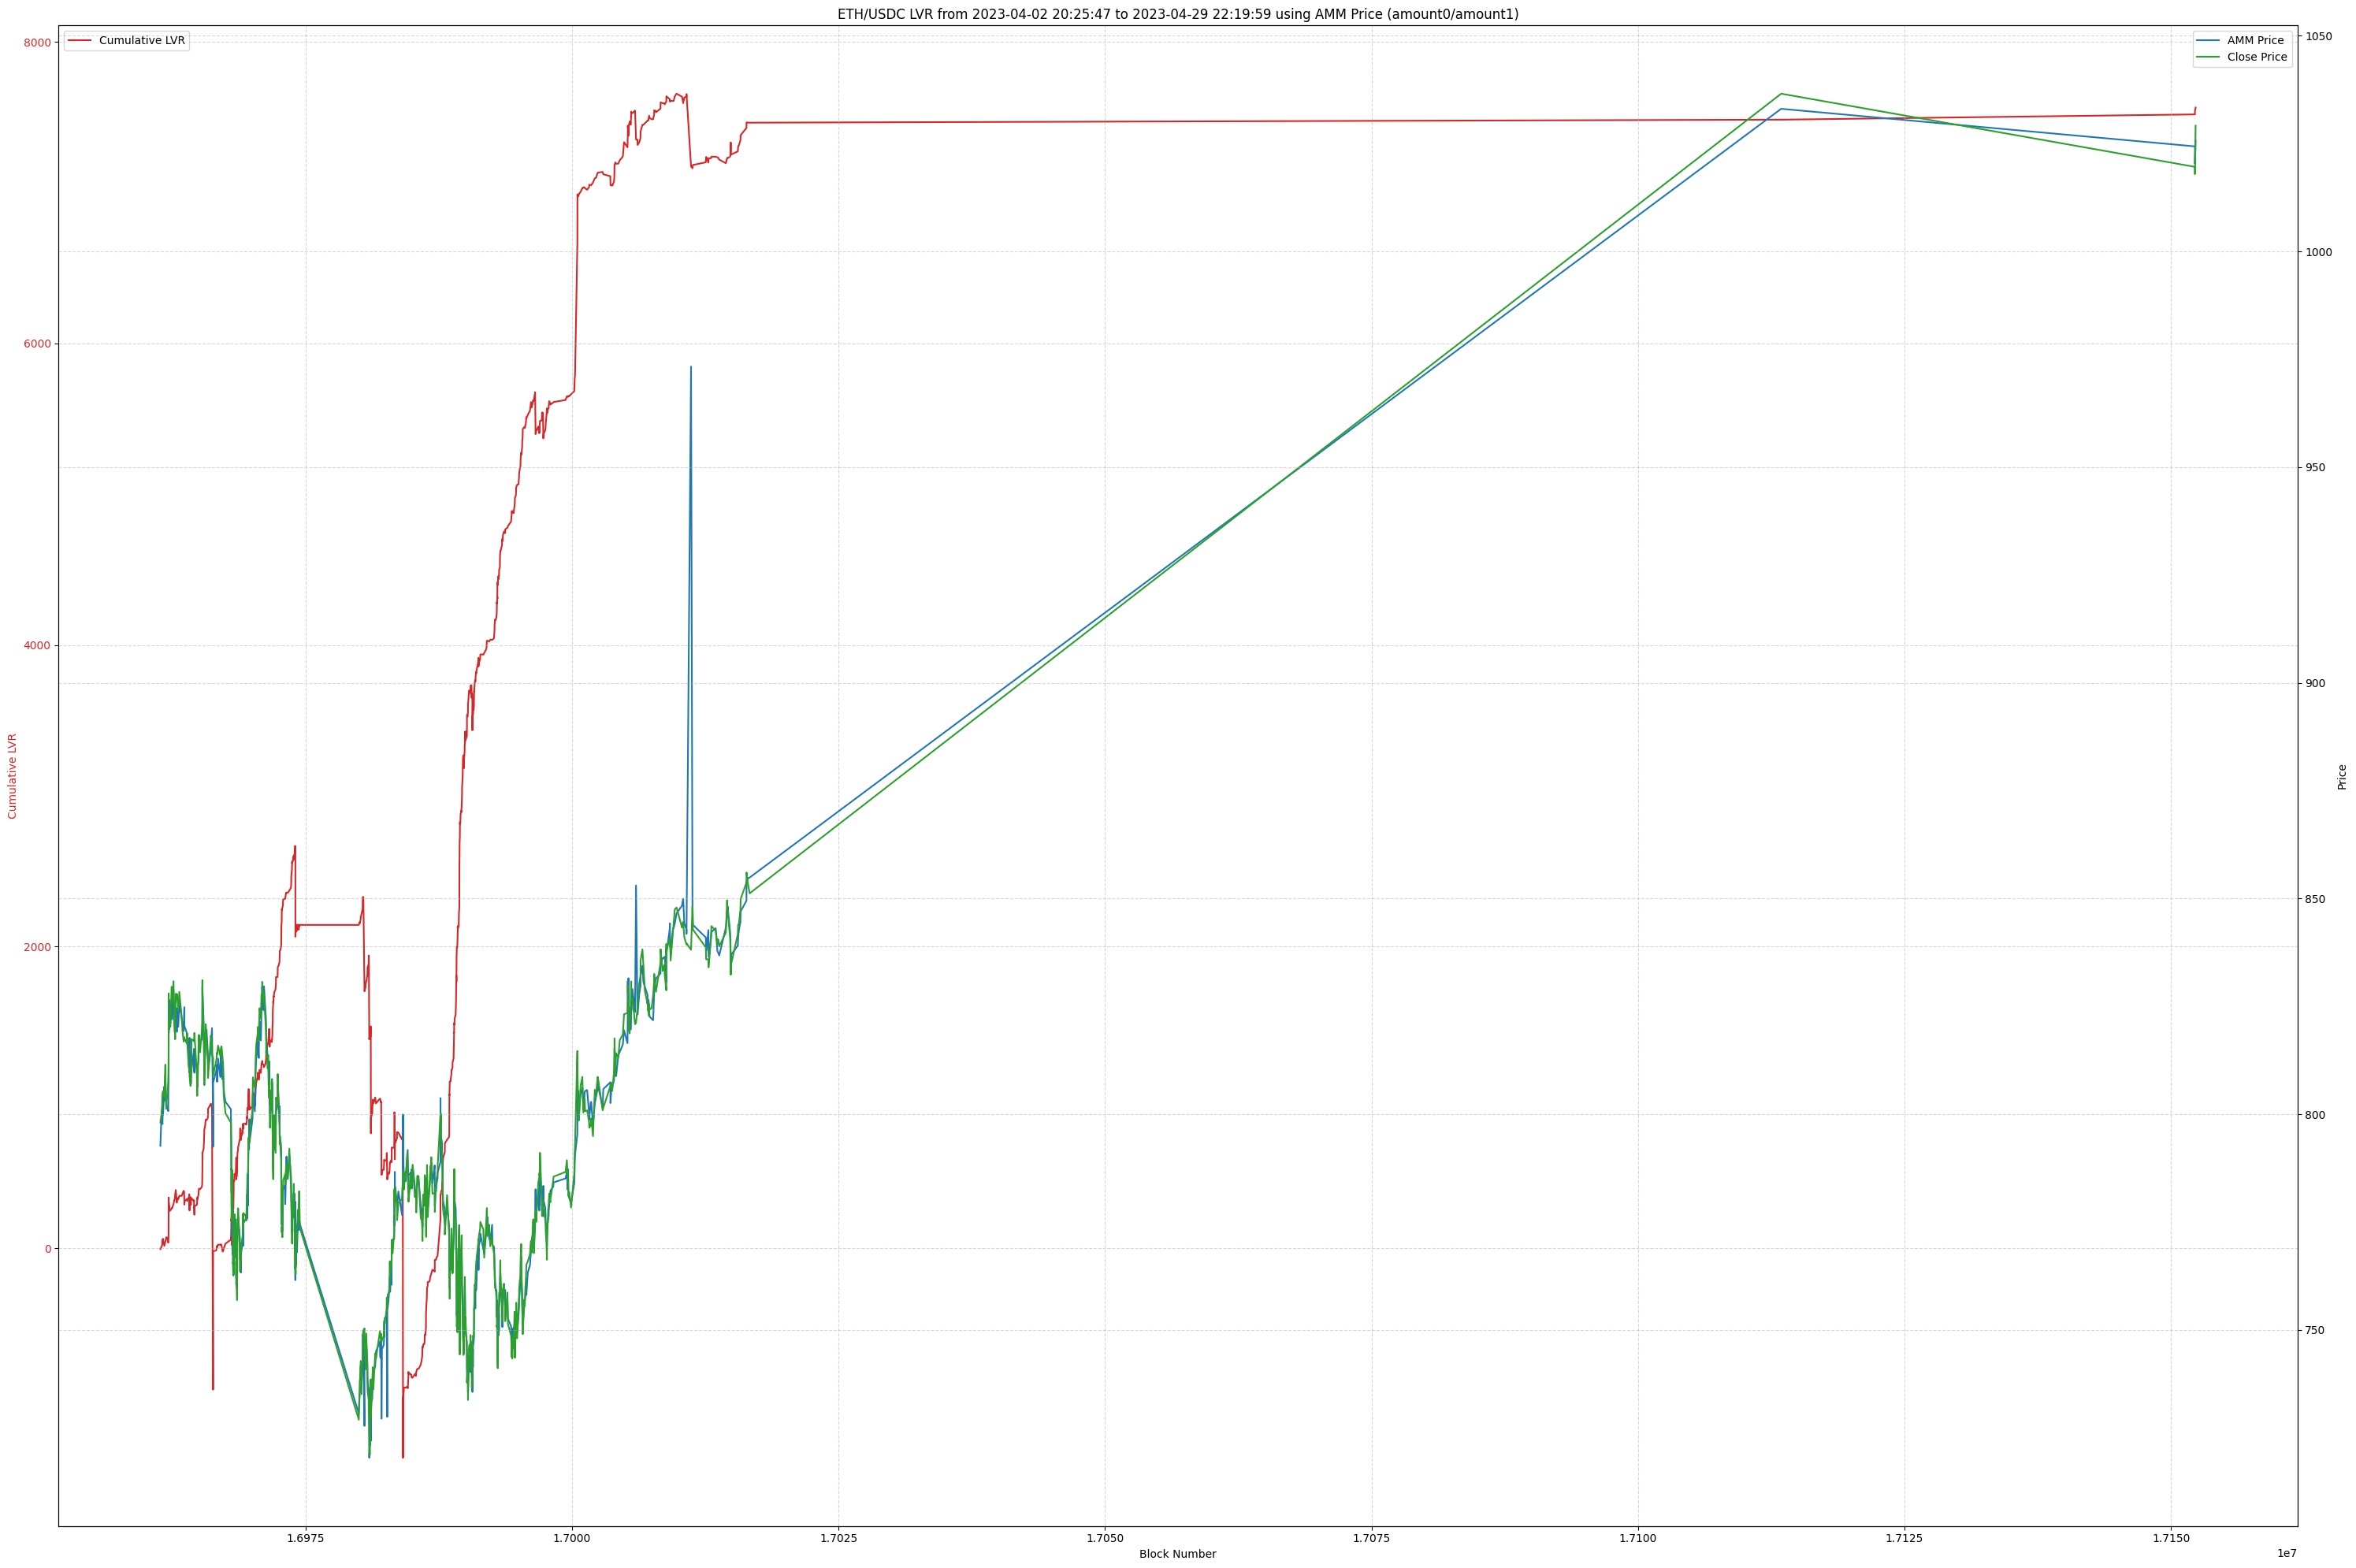

In [148]:
import matplotlib.pyplot as plt

# Increase figure size
fig, ax1 = plt.subplots(figsize=(30, 20))

# Set colors for the lines
color1 = 'tab:red'
color2 = 'tab:blue'
color3 = 'tab:green'

# Plot the data
ax1.plot(merged['block_number'], merged['cum_LVR'], color=color1, label='Cumulative LVR', zorder=1)
ax1.set_xlabel('Block Number')
ax1.set_ylabel('Cumulative LVR', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(merged['block_number'], merged['AMM_price'], color=color2, label='AMM Price', zorder=1)
ax2.plot(merged['block_number'], merged['Close_price'], color=color3, label='Close Price', zorder=1)
ax2.set_ylabel('Price', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Set grid lines
ax1.grid(True, linestyle='--', alpha=0.5, zorder=0)
ax2.grid(True, linestyle='--', alpha=0.5, zorder=0)

# Set legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Get timestamp from first and last item
first_timestamp = merged['timestamp'].iloc[0]
last_timestamp = merged['timestamp'].iloc[-1]

# convert timestamp to datetim
first_timestamp = pd.to_datetime(first_timestamp, unit='s') + pd.Timedelta(hours=8)
last_timestamp = pd.to_datetime(last_timestamp, unit='s') + pd.Timedelta(hours=8)

# Set title and include time period
plt.title(f'ETH/USDC LVR from {first_timestamp} to {last_timestamp} using AMM Price (amount0/amount1)')

# Annotate drastic LVR changes
threshold_change = 10000  # Define the threshold percentage for a drastic change (adjust as needed)

for i in range(1, len(merged)):
    lvr_change = abs(merged['cum_LVR'].iloc[i] - merged['cum_LVR'].iloc[i-1])
    if lvr_change > threshold_change:
        annotation_text = f"Block: {merged['block_number'].iloc[i]:.2f} Close Price: {merged['Close_price'].iloc[i]:.2f}  AMM Price: {merged['AMM_price'].iloc[i]:.2f} USDC Moved: {merged['amount_token0'].iloc[i]:.2f} ETH Moved: {merged['amount_token1'].iloc[i]:.2f} Pool Action: {merged['pool_action'].iloc[i]}  LVR: {merged['LVR'].iloc[i]:.2f}"
        ax1.plot(merged['block_number'].iloc[i], merged['cum_LVR'].iloc[i], 'ro', zorder=2)  # Add a red dot marker
        color = ''
        if merged['LVR'].iloc[i] > 0:
            color = 'green'
        else:
            color = 'red'

        ax1.annotate(annotation_text, xy=(merged['block_number'].iloc[i], merged['cum_LVR'].iloc[i]),
                     xytext=(5, 15), textcoords='offset points', color=color, ha='left', zorder=3)

fig.tight_layout()  # otherwise, the right y-label is slightly clipped
plt.show()


In [154]:
merged['cum_LVR'].iloc[-1]

7564.934892030346

## Using Price from Tick

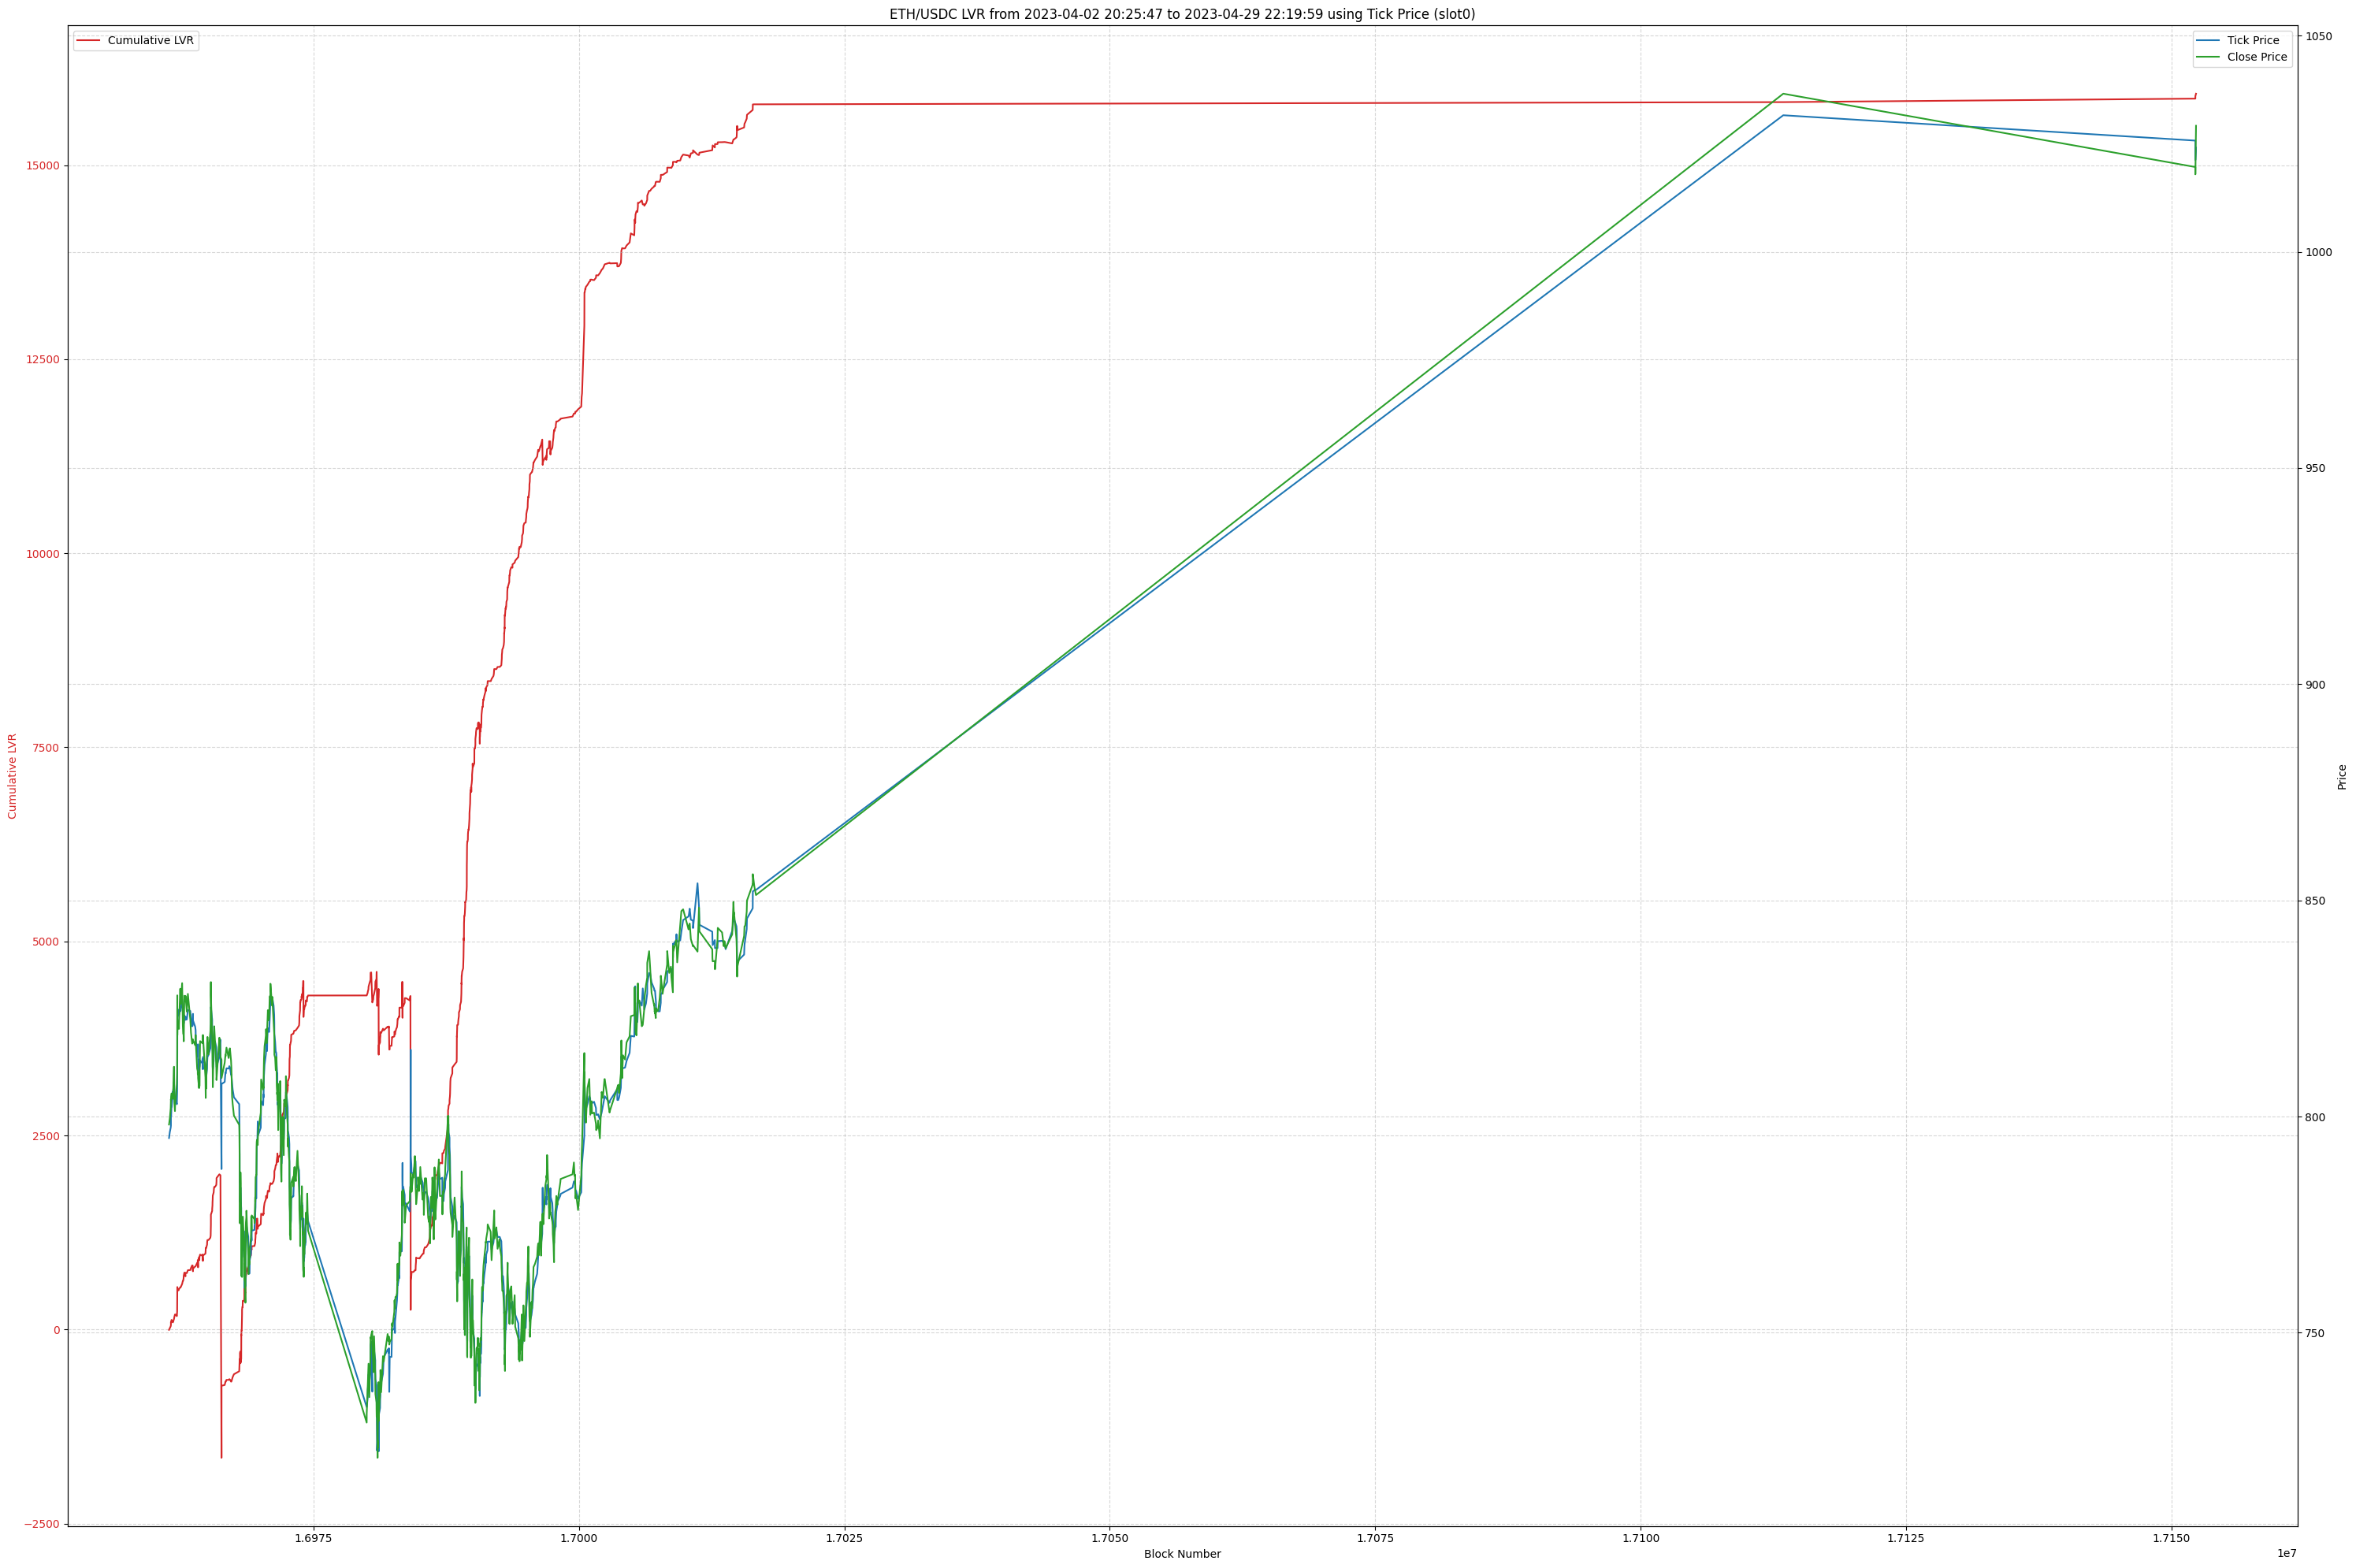

In [153]:
import matplotlib.pyplot as plt

# Increase figure size
fig, ax1 = plt.subplots(figsize=(30, 20))

# Set colors for the lines
color1 = 'tab:red'
color2 = 'tab:blue'
color3 = 'tab:green'

# Plot the data
ax1.plot(merged['block_number'], merged['cum_LVR2'], color=color1, label='Cumulative LVR', zorder=2)
ax1.set_xlabel('Block Number')
ax1.set_ylabel('Cumulative LVR', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(merged['block_number'], merged['Price'], color=color2, label='Tick Price', zorder=3)
ax2.plot(merged['block_number'], merged['Close_price'], color=color3, label='Close Price', zorder=3)
ax2.set_ylabel('Price', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Set grid lines
ax1.grid(True, linestyle='--', alpha=0.5, zorder=0)
ax2.grid(True, linestyle='--', alpha=0.5, zorder=0)

# Set legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Get timestamp from first and last item
first_timestamp = merged['timestamp'].iloc[0]
last_timestamp = merged['timestamp'].iloc[-1]

# convert timestamp to datetim
first_timestamp = pd.to_datetime(first_timestamp, unit='s') + pd.Timedelta(hours=8)
last_timestamp = pd.to_datetime(last_timestamp, unit='s') + pd.Timedelta(hours=8)

# Set title and include time period
plt.title(f'ETH/USDC LVR from {first_timestamp} to {last_timestamp} using Tick Price (slot0)')

# Annotate drastic LVR changes
threshold_change = 10000  # Define the threshold percentage for a drastic change (adjust as needed)

for i in range(1, len(merged)):
    lvr_change = abs(merged['cum_LVR2'].iloc[i] - merged['cum_LVR2'].iloc[i-1])
    if lvr_change > threshold_change:
        annotation_text = f"Block: {merged['block_number'].iloc[i]:.2f} Close Price: {merged['Close_price'].iloc[i]:.2f}  AMM Price: {merged['AMM_price'].iloc[i]:.2f} USDC Moved: {merged['amount_token0'].iloc[i]:.2f} ETH Moved: {merged['amount_token1'].iloc[i]:.2f} Pool Action: {merged['pool_action'].iloc[i]}  LVR: {merged['LVR2'].iloc[i]:.2f}"
        ax1.plot(merged['block_number'].iloc[i], merged['cum_LVR2'].iloc[i], 'ro', zorder=2)  # Add a red dot marker
        color = ''
        if merged['LVR'].iloc[i] > 0:
            color = 'green'
        else:
            color = 'red'

        ax1.annotate(annotation_text, xy=(merged['block_number'].iloc[i], merged['cum_LVR2'].iloc[i]),
                     xytext=(5, 15), textcoords='offset points', color=color, ha='left', zorder=3)

fig.tight_layout()  # otherwise, the right y-label is slightly clipped
plt.show()


In [152]:
merged['cum_LVR2'].iloc[-1]

15920.322903062113

## Using Weighted Average Price across the Block

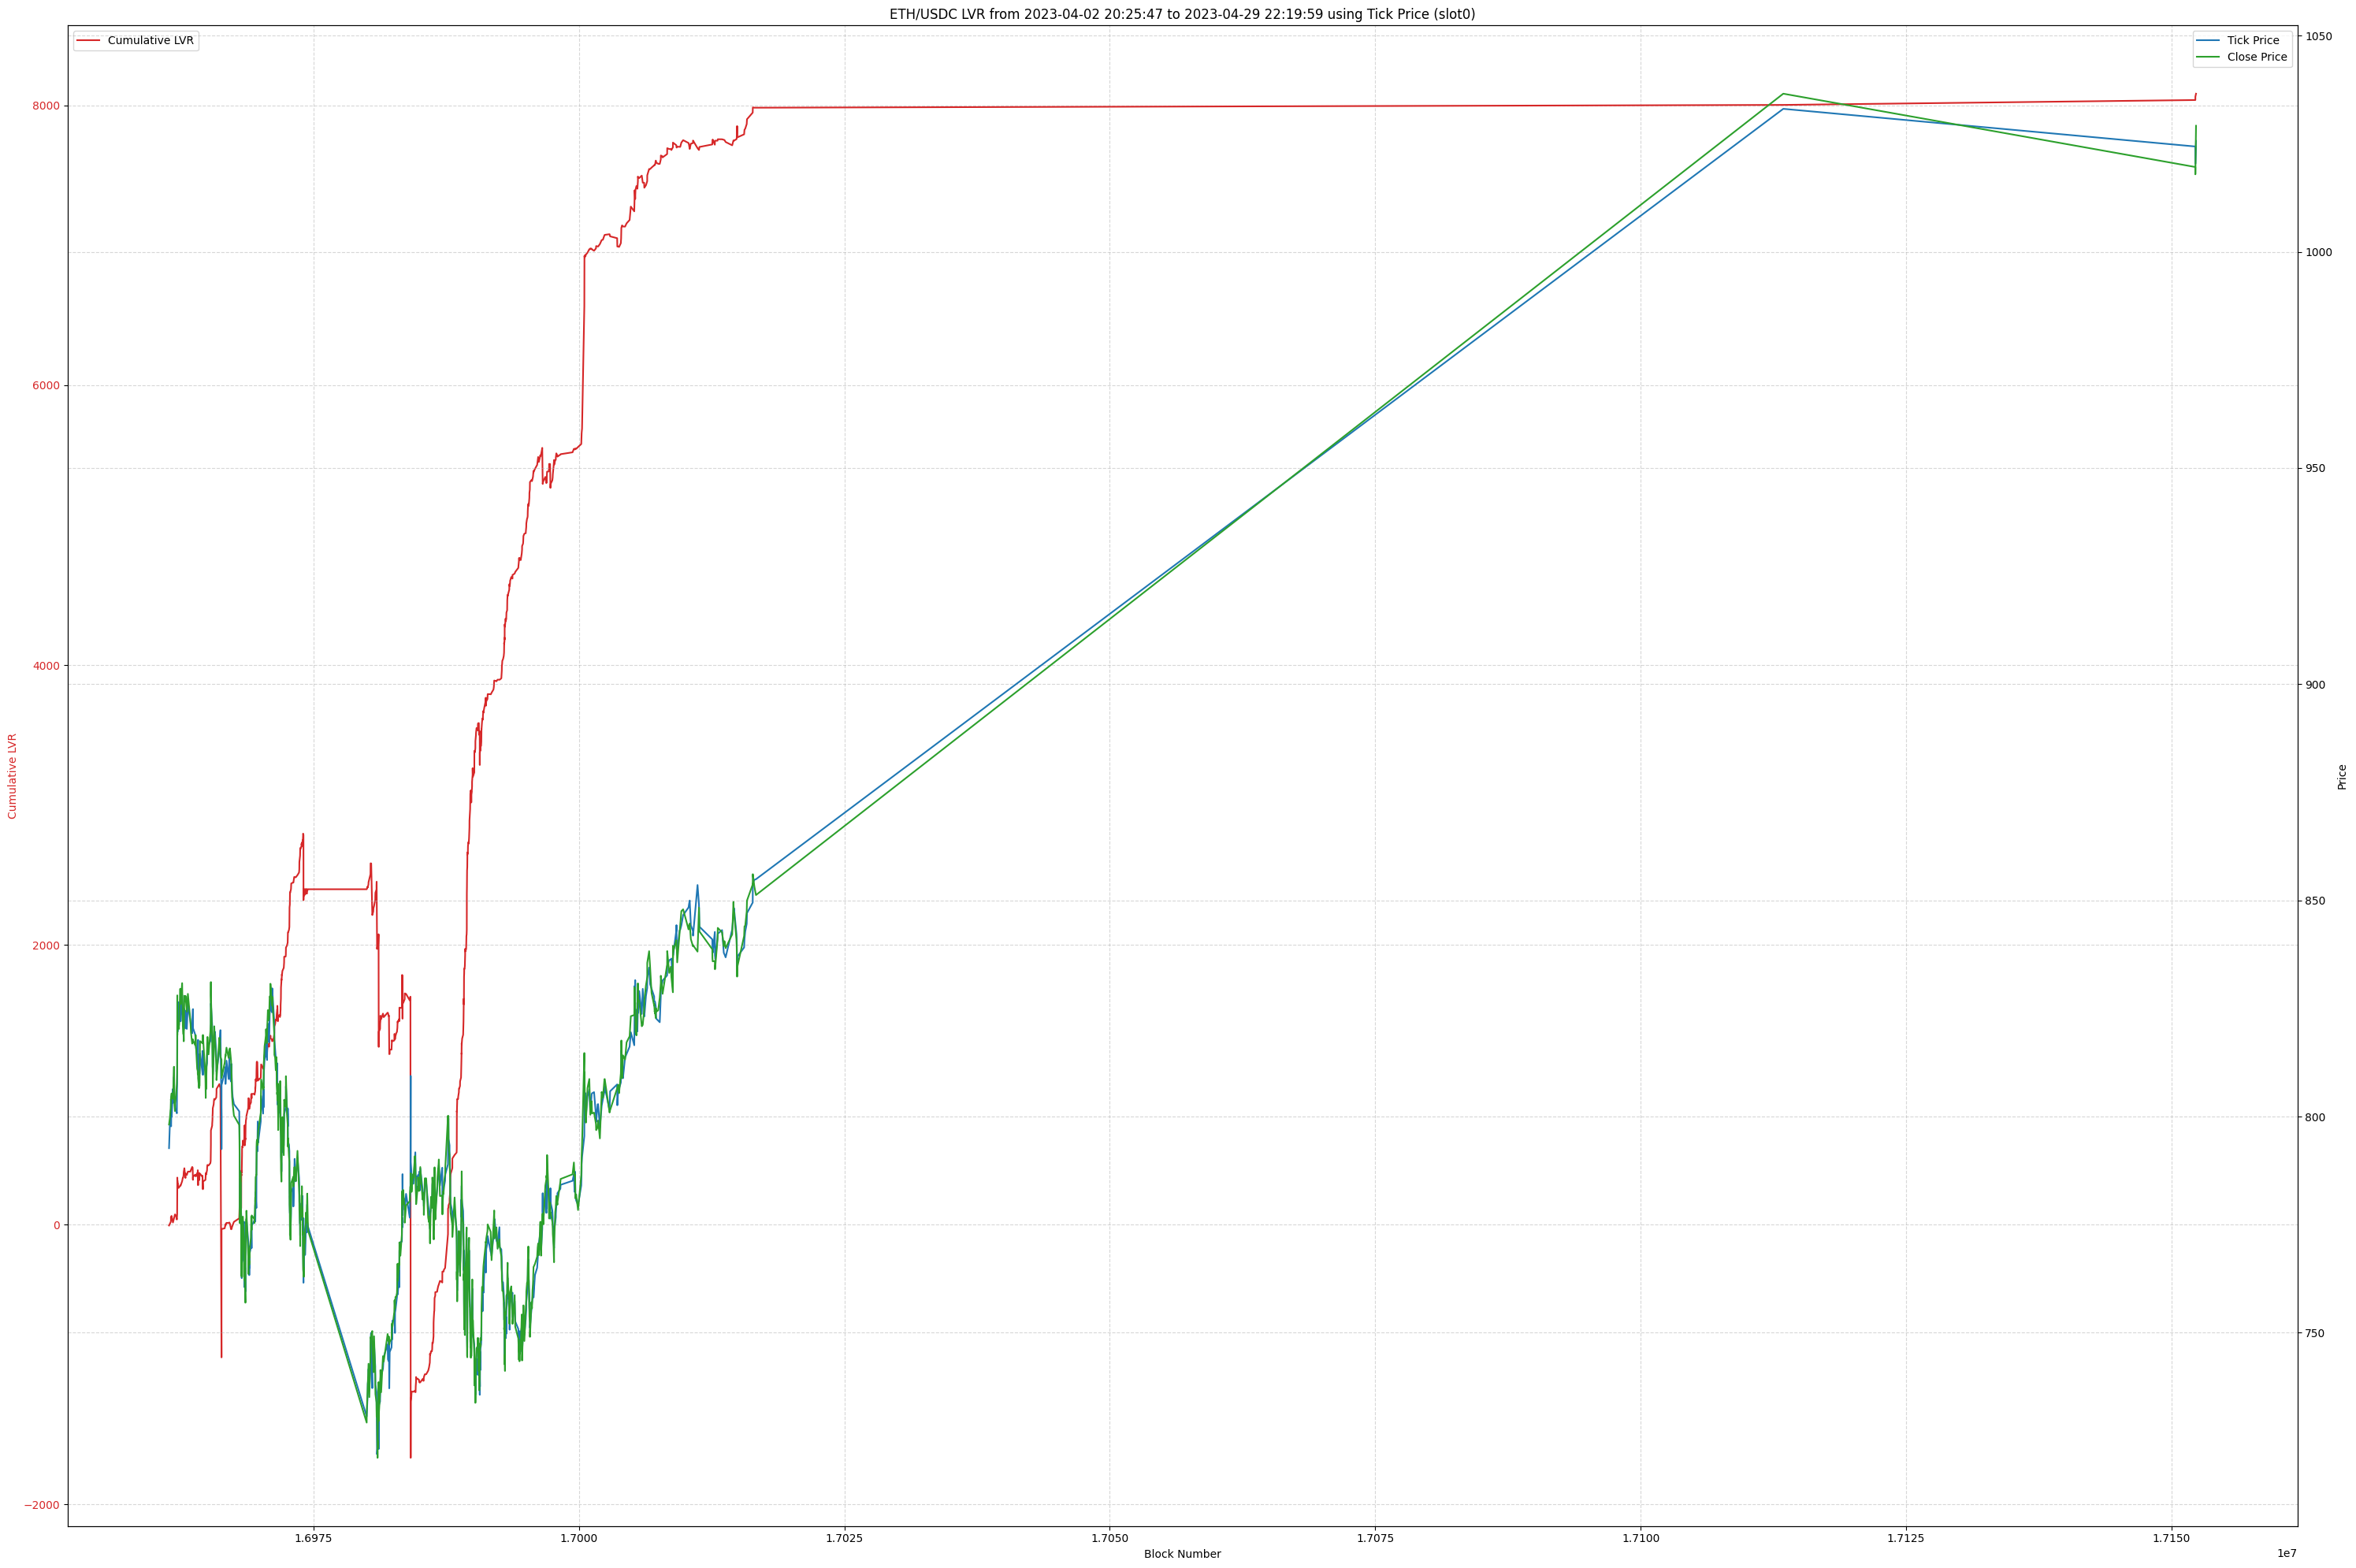

In [155]:
import matplotlib.pyplot as plt

# Increase figure size
fig, ax1 = plt.subplots(figsize=(30, 20))

# Set colors for the lines
color1 = 'tab:red'
color2 = 'tab:blue'
color3 = 'tab:green'

# Plot the data
ax1.plot(merged['block_number'], merged['cum_LVR3'], color=color1, label='Cumulative LVR', zorder=2)
ax1.set_xlabel('Block Number')
ax1.set_ylabel('Cumulative LVR', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(merged['block_number'], merged['AMM_weighted_price'], color=color2, label='Tick Price', zorder=3)
ax2.plot(merged['block_number'], merged['Close_price'], color=color3, label='Close Price', zorder=3)
ax2.set_ylabel('Price', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Set grid lines
ax1.grid(True, linestyle='--', alpha=0.5, zorder=0)
ax2.grid(True, linestyle='--', alpha=0.5, zorder=0)

# Set legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Get timestamp from first and last item
first_timestamp = merged['timestamp'].iloc[0]
last_timestamp = merged['timestamp'].iloc[-1]

# convert timestamp to datetim
first_timestamp = pd.to_datetime(first_timestamp, unit='s') + pd.Timedelta(hours=8)
last_timestamp = pd.to_datetime(last_timestamp, unit='s') + pd.Timedelta(hours=8)

# Set title and include time period
plt.title(f'ETH/USDC LVR from {first_timestamp} to {last_timestamp} using Tick Price (slot0)')

# Annotate drastic LVR changes
threshold_change = 10000  # Define the threshold percentage for a drastic change (adjust as needed)

for i in range(1, len(merged)):
    lvr_change = abs(merged['cum_LVR3'].iloc[i] - merged['cum_LVR3'].iloc[i-1])
    if lvr_change > threshold_change:
        annotation_text = f"Block: {merged['block_number'].iloc[i]:.2f} Close Price: {merged['Close_price'].iloc[i]:.2f}  AMM Price: {merged['AMM_price'].iloc[i]:.2f} USDC Moved: {merged['amount_token0'].iloc[i]:.2f} ETH Moved: {merged['amount_token1'].iloc[i]:.2f} Pool Action: {merged['pool_action'].iloc[i]}  LVR: {merged['LVR3'].iloc[i]:.2f}"
        ax1.plot(merged['block_number'].iloc[i], merged['cum_LVR3'].iloc[i], 'ro', zorder=2)  # Add a red dot marker
        color = ''
        if merged['LVR'].iloc[i] > 0:
            color = 'green'
        else:
            color = 'red'

        ax1.annotate(annotation_text, xy=(merged['block_number'].iloc[i], merged['cum_LVR3'].iloc[i]),
                     xytext=(5, 15), textcoords='offset points', color=color, ha='left', zorder=3)

fig.tight_layout()  # otherwise, the right y-label is slightly clipped
plt.show()


In [156]:
merged['cum_LVR3'].iloc[-1]

8084.176492522774

In [116]:
merged

,timestamp,block_number,Price,AMM_price,AMM_weighted_price,Close_price,amount_token0,amount_token1,pool_action,trader_action,LVR,LVR2,LVR3,cum_LVR,cum_LVR2,cum_LVR3
0,1.680438e+09,16961395,795.019058,792.675374,792.675374,798.139023,-368.394778,0.464749,buy,sell,-2.539223,-1.449999,-2.539223,-2.539223,-1.449999,-2.539223
1,1.680439e+09,16961471,796.451310,798.087341,798.087341,799.602824,2649.767041,-3.320147,sell,buy,5.031627,10.463491,5.031627,2.492404,9.013491,2.492404
2,1.680440e+09,16961551,797.407577,799.311522,799.311522,801.919505,1746.136954,-2.184551,sell,buy,5.697272,9.856537,5.697272,8.189676,18.870028,8.189676
3,1.680441e+09,16961573,797.886141,800.036105,800.036105,803.991131,854.181749,-1.067679,sell,buy,4.222698,6.518169,4.222698,12.412373,25.388197,12.412373
4,1.680441e+09,16961574,800.363302,801.512909,801.512909,803.594858,4431.943212,-5.529472,sell,buy,11.512082,17.868799,11.512082,23.924455,43.256995,23.924455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.681116e+09,17016673,852.405713,854.882703,854.882703,851.221968,17.343635,-0.020288,sell,buy,-0.074268,-0.024016,-0.074268,3194.184922,6680.885722,3424.250386
996,1.682306e+09,17113430,1031.586372,1033.069191,1033.069191,1036.572222,3265.256565,-3.160734,sell,buy,11.072150,15.758945,11.072150,3205.257072,6696.644667,3435.322536
997,1.682777e+09,17152242,1025.723348,1024.357061,1024.357061,1019.610459,-4016.678407,3.921170,buy,sell,18.612235,23.969679,18.612235,3223.869307,6720.614346,3453.934771
998,1.682777e+09,17152243,1021.220304,1020.345587,1020.345587,1017.923323,-5338.584814,5.232134,buy,sell,12.673609,17.250250,12.673609,3236.542916,6737.864596,3466.608380


In [123]:
# get item at index 995 and 996
sample = merged.iloc[995:997]

# create a new column to store the datetime
sample['datetime'] = pd.to_datetime(sample['timestamp'], unit='s') + pd.Timedelta(hours=8)

# get the duration between 995 and 996
duration = sample['datetime'].iloc[1] - sample['datetime'].iloc[0]

# print the duration
print(duration)


13 days 18:40:48


/var/folders/lv/l4xn1q3s7jxgwb_811k8vqrh0000gn/T/ipykernel_67873/265268816.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['datetime'] = pd.to_datetime(sample['timestamp'], unit='s') + pd.Timedelta(hours=8)


In [124]:
sample

,timestamp,block_number,Price,AMM_price,AMM_weighted_price,Close_price,amount_token0,amount_token1,pool_action,trader_action,LVR,LVR2,LVR3,cum_LVR,cum_LVR2,cum_LVR3,datetime
995,1.681116e+09,17016673,852.405713,854.882703,854.882703,851.221968,17.343635,-0.020288,sell,buy,-0.074268,-0.024016,-0.074268,3194.184922,6680.885722,3424.250386,2023-04-10 16:38:47
996,1.682306e+09,17113430,1031.586372,1033.069191,1033.069191,1036.572222,3265.256565,-3.160734,sell,buy,11.072150,15.758945,11.072150,3205.257072,6696.644667,3435.322536,2023-04-24 11:19:35


In [157]:
# compile the results in a table
results = pd.DataFrame({
                        'Time Period': [f'{first_timestamp} to {last_timestamp}'],
                        'Total LVR1': [merged['cum_LVR'].iloc[-1]],
                        'Total LVR2': [merged['cum_LVR2'].iloc[-1]],
                        'Total LVR3': [merged['cum_LVR3'].iloc[-1]],})

results


,Time Period,Total LVR1,Total LVR2,Total LVR3
0,2023-04-02 20:25:47 to 2023-04-29 22:19:59,7564.934892,15920.322903,8084.176493
